# 练习3：多分类任务与神经网络

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
from scipy.special import expit #Vectorized sigmoid function
from scipy.io import loadmat

## 多分类任务

### 查看数据

ex3data1.mat总共有5000个样本，每个样本是一个20 $\times$ 20像素的灰度图片。每个像素由一个浮点数表示，该数字指示该位置的灰度强度。即样本 $X$ 中的每一行就是 20 $\times$ 20像素展开的400维向量，每一行即一个训练实例，代表一个手写数字的灰度图片。 

目标 $y$ 为一个5000维的向量，储存样本真实标记。其中，数字 $0$ 用 $10$ 来代替。

In [6]:
data = loadmat('./data/ex3data1.mat')
X = data['X']
y = data['y']
# 需要对 X 进行转置
X = np.array([im.reshape((20, 20)).T for im in X])
X = np.array([im.reshape(400) for im in X])
np.transpose(y)
X.shape, y.shape

((5000, 400), (5000, 1))

In [7]:
#绘图函数
def plot_an_image(image):
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20, 20)), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))  # 不显示坐标
    plt.yticks(np.array([]))

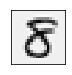

8

In [8]:
pick_one = np.random.randint(0, 5000)
plot_an_image(X[pick_one, :])
plt.show()
y[pick_one][0]

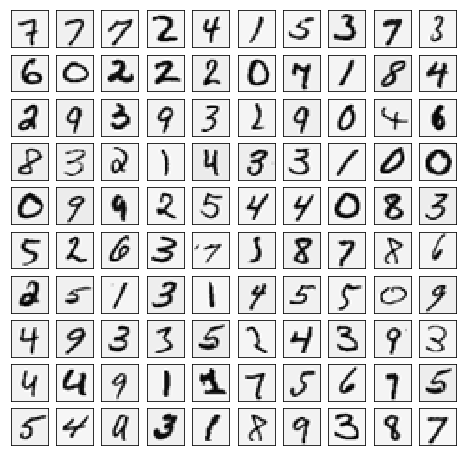

In [9]:
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  

# 显示100个样本           
plot_100_image(X)
plt.show()

### 初始化变量

In [10]:
X = np.insert(X,0,1,axis=1)
X = np.matrix(X)
y = np.matrix(y)

X.shape, y.shape

((5000, 401), (5000, 1))

### 向量化逻辑回归

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [12]:
# 计算代价函数
def computeRegCost(theta, X, y, mylambda=0.):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    m = len(X)
    cost = np.multiply(-y, np.log(sigmoid(np.dot(X , theta.T)))) - np.multiply((1-y), np.log(1-(sigmoid(np.dot(X , theta.T)))))
    reg = (mylambda/(2*m)) * (np.sum(np.power(theta[:,1:theta.shape[1]], 2)))
    
    return (np.sum(cost)/((len(X))) + reg)

### 向量化梯度下降

$ Repeat\ until\ convergence\{\\ \theta_0:=\theta_0-\alpha\frac{1}{m}\sum\limits_{i=1}^m [(h_{\theta}(x^{(i)})-y^{(i)})x_0^{(i)}] \\ \begin{aligned} \theta_j & :=\theta_j-\alpha\frac{1}{m}\sum\limits_{i=1}^m [(h_{\theta}(x^{(i)})-y^{(i)})x^{(i)} + \frac{\lambda}{m}\theta_j] \\& for \ j=1,2,..,n\\\ \end{aligned} $



![](./img/vectorize.png)

In [13]:
# m个样本，n个特征
# 计算迭代一次的梯度
def computeRegGradient(theta, X, y, mylambda=0.):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    m = len(X)
    n = theta.shape[1]  

    cost = sigmoid(np.dot(X , theta.T)) - y 
    temp = (X.T * cost).T + (mylambda/m) * theta 
    
    # 第一个参数也就是 theta0 不参与正则化
    temp[0, 0] = np.sum(np.multiply(cost, X[:,0])) / m 
    
    return np.array(temp).ravel() # 维度 1 * n 又转回数组，因为优化函数要求的是 1D ndarray

### One vs All

In [14]:
from scipy.optimize import optimize
import scipy.optimize as opt

In [15]:
def build_theta(X, y, label_num, mylambda=0.): #标签数决定了做多少次二分类
    
    # 初始化参数矩阵
    theta_all = np.matrix(np.zeros((label_num, X.shape[1]))) # 10*401
    for i in range(label_num):
        y_one = np.matrix([1 if label == (i+1) else 0 for label in y]).T
        theta_one = np.matrix(np.zeros((1, X.shape[1])))
        result_one = optimize.fmin_cg(f=computeRegCost, x0=theta_one, fprime=computeRegGradient, args=(X, y_one,mylambda), maxiter=100,disp=False, full_output=True)
        theta_all[i,:] = result_one[0]
        print('最小化目标 数字 %d，最小化后的代价值：%f' %(i+1,result_one[1]))
    
    print('完成最小化')
    
    return theta_all

In [16]:
label_num = 10
theta_new = build_theta(X, y, label_num)

最小化目标 数字 1，最小化后的代价值：0.002985
最小化目标 数字 2，最小化后的代价值：0.051845
最小化目标 数字 3，最小化后的代价值：0.067662
最小化目标 数字 4，最小化后的代价值：0.026932
最小化目标 数字 5，最小化后的代价值：0.045856
最小化目标 数字 6，最小化后的代价值：0.009140
最小化目标 数字 7，最小化后的代价值：0.024177
最小化目标 数字 8，最小化后的代价值：0.117253
最小化目标 数字 9，最小化后的代价值：0.080191
最小化目标 数字 10，最小化后的代价值：0.003950
完成最小化


### 预测

In [17]:
def predict_all(X, theta_all):
    # 转换为矩阵    
    all_theta = np.matrix(theta_all)
    # 计算假设函数，注意此时得到是 5000 * 10 维的矩阵，每一行的10个数值即表示与对应10个数字的拟合程度
    h = sigmoid(X * theta_all.T)  
    # 每一行保留数值（也就是概率）最大的值，其 列标+1 即为对应的手写数字
    h_new = np.argmax(h, axis=1) + 1
    
    return h_new

In [18]:
y_pred = predict_all(X, theta_new)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred,y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 95.94%


In [38]:
y_pred

matrix([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 6],
        [10]], dtype=int64)

## 神经网络

### 下图是神经网络模型

![nn](./img/nn.png)

### 查看数据

数据集有已经训练好的权重参数 $\theta_1、\theta_2$

In [3]:
data = loadmat('./data/ex3weights.mat')
Theta1 = data['Theta1']
Theta2 = data['Theta2']

theta_list = []
theta_list.append(Theta1)
theta_list.append(Theta2)

Theta1.shape, Theta2.shape

((25, 401), (10, 26))

### Feedforward Propagation 前向传播

In [4]:
def FP(X, theta_list):
    a = np.matrix(X)
    for (i, theta) in enumerate(theta_list):
        theta = np.matrix(theta)
        z = a * theta.T
        a = sigmoid(z)
        if i != (len(theta_list)-1):
            a = np.insert(a,0,1,axis=1)
            
    h = np.argmax(a, axis=1) + 1
    return h        

#### 提供的参数 $\theta$ 是在原始数据集上训练的，所以我们需要使用没经过转置的数据集

In [5]:
data = loadmat('./data/ex3data1.mat')
X = data['X']
y = data['y']

X = np.insert(X, 0, 1, axis=1)  # intercept

X.shape, y.shape

((5000, 401), (5000, 1))

In [9]:
h = FP(X, theta_list)

In [10]:
correct = [1 if a == b else 0 for (a, b) in zip(h,y)]
accuracy1 = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy1 * 100))

accuracy = 97.52%
